# Weight selection

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from torch import Tensor
import torch.nn as nn
import torch.cuda as cuda
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter

try:
    import accimage
except ImportError:
    accimage = None

import random
import copy

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils

import struct
import glob
import datetime
import time
import re

from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from PIL import Image

## Model

In [2]:
# learning rule

class STDP(nn.Module):

    def __init__(self, conv_layer, learning_rate, use_stabilizer = True, lower_bound = 0, upper_bound = 1):
        super(STDP, self).__init__()
        self.conv_layer = conv_layer
        if isinstance(learning_rate, list):
            self.learning_rate = learning_rate
        else:
            self.learning_rate = [learning_rate] * conv_layer.out_channels
        for i in range(conv_layer.out_channels):
            self.learning_rate[i] = (Parameter(torch.tensor([self.learning_rate[i][0]])),
                            Parameter(torch.tensor([self.learning_rate[i][1]])))
            self.register_parameter('ltp_' + str(i), self.learning_rate[i][0])
            self.register_parameter('ltd_' + str(i), self.learning_rate[i][1])
            self.learning_rate[i][0].requires_grad_(False)
            self.learning_rate[i][1].requires_grad_(False)
        self.use_stabilizer = use_stabilizer
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

    def get_pre_post_ordering(self, input_spikes, output_spikes, winners):

        # accumulating input and output spikes to get latencies
        input_latencies = torch.sum(input_spikes, dim=0)
        output_latencies = torch.sum(output_spikes, dim=0)
        result = []
        for winner in winners:
            # generating repeated output tensor with the same size of the receptive field
            out_tensor = torch.ones(*self.conv_layer.kernel_size, device=output_latencies.device) * output_latencies[winner]
            # slicing input tensor with the same size of the receptive field centered around winner
            # since there is no padding, there is no need to shift it to the center
            in_tensor = input_latencies[:,winner[-2]:winner[-2]+self.conv_layer.kernel_size[-2],winner[-1]:winner[-1]+self.conv_layer.kernel_size[-1]]
            result.append(torch.ge(in_tensor,out_tensor))
        return result

    # simple STDP rule with weights freezing    
    # gets prepost pairings, winners, weights, and learning rates (all shoud be tensors)
    def forward(self, input_spikes, potentials, output_spikes, winners=None, \
                freeze_tensor=None, kwta = 1, inhibition_radius = 0):
        
        if winners is None:
            winners = sf.get_k_winners(potentials, kwta, inhibition_radius, output_spikes)
        pairings = self.get_pre_post_ordering(input_spikes, output_spikes, winners)

        lr = torch.zeros_like(self.conv_layer.weight)
        for i in range(len(winners)):
            f = winners[i][0]
            lr[f] = torch.where(pairings[i], *(self.learning_rate[f]))

        # additional script for weights freezing    
        if freeze_tensor is None:
            self.conv_layer.weight += lr * ((self.conv_layer.weight-self.lower_bound) * \
                                (self.upper_bound-self.conv_layer.weight) if self.use_stabilizer else 1)
        else:
            ones_like_freeze_tensor = torch.full_like(freeze_tensor, 1)
            zero_like_freeze_tensor = torch.zeros_like(freeze_tensor)

            # condition 'freeze_tensor > 0.01' is stronger version of 'freeze_tensor > 0' for insure
            anti_freeze_tensor_byte = torch.where(freeze_tensor > 0.01, zero_like_freeze_tensor, ones_like_freeze_tensor)
            self.conv_layer.weight += lr * ((self.conv_layer.weight-self.lower_bound) * \
                                (self.upper_bound-self.conv_layer.weight) if self.use_stabilizer else 1) * \
                                anti_freeze_tensor_byte

        self.conv_layer.weight.clamp_(self.lower_bound, self.upper_bound)

    def update_learning_rate(self, feature, ap, an):

        self.learning_rate[feature][0][0] = ap
        self.learning_rate[feature][1][0] = an

    def update_all_learning_rate(self, ap, an):

        for feature in range(self.conv_layer.out_channels):
            self.learning_rate[feature][0][0] = ap
            self.learning_rate[feature][1][0] = an

In [3]:
# model

class MozafariMNIST2018(nn.Module):
    
    def __init__(self, dropout=0.5, dropout_procedure = False):
        
        super(MozafariMNIST2018, self).__init__()

        self.conv1 = snn.Convolution(6, 30, 5, 0.8, 0.05)
        self.conv1_t = 15
        self.k1 = 5
        self.r1 = 3

        self.conv2 = snn.Convolution(30, 250, 3, 0.8, 0.05)
        self.conv2_t = 10
        self.k2 = 8
        self.r2 = 1

        self.conv3 = snn.Convolution(250, 200, 5, 0.8, 0.05)
        self.number_of_features = 200
        
        self.dropout = dropout

        self.stdp1 = STDP(self.conv1, (0.004, -0.003))                        
        self.stdp2 = STDP(self.conv2, (0.004, -0.003))                        
        self.stdp3 = STDP(self.conv3, (0.004, -0.003), False, 0.2, 0.8)       
        self.anti_stdp3 = STDP(self.conv3, (-0.004, 0.0005), False, 0.2, 0.8) 
        self.max_ap = Parameter(torch.Tensor([0.15]))

        self.decision_map = []
        for i in range(10):
            self.decision_map.extend([i]*20)

        self.ctx = {"input_spikes":None, "potentials":None, \
                    "output_spikes":None, "winners":None, \
                    "freeze_tensor":None}                           # freeze_tensor was added             
        self.spk_cnt1 = 0
        self.spk_cnt2 = 0
        
        self.dropout_procedure = dropout_procedure
        
    def forward(self, input, max_layer, freeze_tensor=None):    # freeze_tensor was added
        
        input = sf.pad(input.float(), (2,2,2,2), 0)
        
        if self.training:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                self.spk_cnt1 += 1
                if self.spk_cnt1 >= 500:
                    self.spk_cnt1 = 0
                    ap = torch.tensor(self.stdp1.learning_rate[0][0].item(), device=self.stdp1.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp1.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k1, self.r1, spk)
                self.ctx["input_spikes"] = input
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1))
            pot = self.conv2(spk_in)
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                self.spk_cnt2 += 1
                if self.spk_cnt2 >= 500:
                    self.spk_cnt2 = 0
                    ap = torch.tensor(self.stdp2.learning_rate[0][0].item(), device=self.stdp2.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp2.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k2, self.r2, spk)
                self.ctx["input_spikes"] = spk_in
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2))
            pot = self.conv3(spk_in)           
            
            if self.dropout_procedure:
                dropout = torch.ones(self.number_of_features) * self.dropout
                to_be_dropped = torch.bernoulli(dropout).nonzero()   
                sf.feature_inhibition_(pot, to_be_dropped)
            
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            self.ctx["input_spikes"] = spk_in
            self.ctx["potentials"] = pot
            self.ctx["output_spikes"] = spk
            self.ctx["winners"] = winners
            self.ctx["freeze_tensor"] = freeze_tensor

            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output
        
        else:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                return spk, pot
            
            pot = self.conv2(sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1)))
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                return spk, pot
            pot = self.conv3(sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2)))
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output

    def stdp(self, layer_idx):
        if layer_idx == 1:
            self.stdp1(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"], self.ctx["freeze_tensor"])
        if layer_idx == 2:
            self.stdp2(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"], self.ctx["freeze_tensor"])

    def update_learning_rates(self, stdp_ap, stdp_an, anti_stdp_ap, anti_stdp_an):
               
        self.stdp3.update_all_learning_rate(stdp_ap, stdp_an)
        self.anti_stdp3.update_all_learning_rate(anti_stdp_an, anti_stdp_ap)  
 
    def reward(self):
        self.stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"], self.ctx["freeze_tensor"])

    def punish(self):
        self.anti_stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"], self.ctx["freeze_tensor"])
        

In [4]:
# train and test

def train_unsupervise(network, data, layer_idx):
    network.train()
    
    for i in range(len(data)):
        data_in = data[i]
        if use_cuda:
            data_in = data_in.cuda()
        network(data_in, layer_idx)
        network.stdp(layer_idx)

def train_rl(network, data, target, freeze_tensor=None):
    network.train()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3, freeze_tensor)    # freeze_tensor was added
        if d != -1:
            if d == target_in:
                perf[0]+=1
                network.reward() 
            else:
                perf[1]+=1
                network.punish()  
        else:
            perf[2]+=1
    return perf/len(data)

def test(network, data, target):
    network.eval()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
            else:
                perf[1]+=1
        else:
            perf[2]+=1
    return perf/len(data)

In [5]:
# for image transformation (see dataset)

class S1C1Transform:
    
    def __init__(self, filter, PIL_type=False, timesteps = 15):
        self.PIL_type = PIL_type
        self.to_pil_image = transforms.ToPILImage()    
        self.to_tensor = transforms.ToTensor()
        self.filter = filter
        self.temporal_transform = utils.Intensity2Latency(timesteps)
        self.cnt = 0
        
    def __call__(self, image):
        #if self.cnt % 10000 == 0:
        #    print(f'{self.cnt} images')
        if self.PIL_type:
            image = self.to_pil_image(image)
        self.cnt+=1
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0)
        image = self.filter(image)
        image = sf.local_normalization(image, 8)
        temporal_image = self.temporal_transform(image)
        return temporal_image.sign().byte()

In [6]:
# for image transformation (see dataset)

kernels = [ utils.DoGKernel(3,3/9,6/9),
            utils.DoGKernel(3,6/9,3/9),
            utils.DoGKernel(7,7/9,14/9),
            utils.DoGKernel(7,14/9,7/9),
            utils.DoGKernel(13,13/9,26/9),
            utils.DoGKernel(13,26/9,13/9)]

filter = utils.Filter(kernels, padding = 6, thresholds = 50)

s1c1 = S1C1Transform(filter)
s1c1_PIL = S1C1Transform(filter, PIL_type=True)

In [8]:
def curve_graph(parametr_set):

    plt.subplots(figsize=(15, 5))

    plt.plot(parametr_set['epoch'], parametr_set['train']*100, color='cyan', label='train')
    plt.plot(parametr_set['epoch'], parametr_set['test']*100, color='blue', marker = 'o', label='test')
    plt.plot(parametr_set['epoch'], parametr_set['test_previous']*100, linestyle = ':', color='red', label='test of previous images')
    plt.xlabel('epochs', loc='right', fontsize=17)
    plt.ylabel('accuracy, %',  loc='top', fontsize=17)
    plt.grid()
    plt.legend()
    plt.show()

In [9]:
# for image transformation (see dataset)

class CustomTensorDataset(Dataset):
    
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [10]:
# prediction

def pred(network, data, target):
    prediction_d = []
    target_ = [] 
    network.eval()
    
    for i in range(len(data)):
        
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        pred_d = network(data_in, 3)
            
        prediction_d.append(pred_d)
        target_.append(target_in)
        
    return prediction_d, target_

## Sets

### Set of capital letters
24000 train images + 4000 test images

In [11]:
# set of 10 capital letters from EMNIST
path = f'./data/EMNIST_own/capital_letters/'

test_letter_labels = torch.load(f'{path}Mozafari_capital_letters_test_labels.pt', map_location=torch.device('cpu'))
test_letters = torch.load(f'{path}Mozafari_capital_letters_test_images.pt', map_location=torch.device('cpu'))

train_letter_labels = torch.load(f'{path}Mozafari_capital_letters_train_labels.pt', map_location=torch.device('cpu'))
train_letters = torch.load(f'{path}Mozafari_capital_letters_train_images.pt', map_location=torch.device('cpu'))

In [12]:
# Element permutation

train_order_l = torch.randperm(train_letter_labels.shape[0])
test_order_l = torch.randperm(test_letter_labels.shape[0])

train_letter_labels = train_letter_labels[train_order_l].view(train_letter_labels.size())
train_letters = train_letters[train_order_l].view(train_letters.size())

test_letter_labels = test_letter_labels[test_order_l].view(test_letter_labels.size())
test_letters = test_letters[test_order_l].view(test_letters.size())

In [13]:
train_letter_labels.size(), test_letter_labels.size()

(torch.Size([24000]), torch.Size([4000]))

In [14]:
train_letter_set = CustomTensorDataset(tensors=(train_letters, train_letter_labels), transform=s1c1_PIL)
test_letter_set = CustomTensorDataset(tensors=(test_letters, test_letter_labels), transform=s1c1_PIL)

train_letter_loader = DataLoader(train_letter_set, batch_size=len(train_letter_set))
test_letter_loader = DataLoader(test_letter_set, batch_size=len(test_letter_set))

### Set of 10 MNIST digits
Reduction the set of 60000 train + 10000 test images to the set of 24000 train + 4000 test images

In [15]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [16]:
# the set of 10 digit images, the same size as the set of letters (2400 trains + 400 tests per class)
# the MNIST data was pre-divided into 10 classes
path = f'./data/MNIST_0_1_2_3_4_5_6_7_8_9/'

for i in classes: 
    globals()[f'train_digit_{i}_images'] = torch.load(f'{path}train_images_{i}.pt', map_location=torch.device('cpu'))[0:2400]
    globals()[f'train_digit_{i}_labels'] = torch.load(f'{path}train_labels_{i}.pt', map_location=torch.device('cpu'))[0:2400]
    globals()[f'test_digit_{i}_images'] = torch.load(f'{path}test_images_{i}.pt', map_location=torch.device('cpu'))[0:400]
    globals()[f'test_digit_{i}_labels'] = torch.load(f'{path}test_labels_{i}.pt', map_location=torch.device('cpu'))[0:400]

train_MNIST_labels = globals()[f'train_digit_0_labels']
train_MNIST_images = globals()[f'train_digit_0_images']
test_MNIST_labels = globals()[f'test_digit_0_labels']
test_MNIST_images = globals()[f'test_digit_0_images']                                 

for i in range(1, 10):
    train_MNIST_labels = torch.cat((train_MNIST_labels, globals()[f'train_digit_{i}_labels']), 0)
    train_MNIST_images = torch.cat((train_MNIST_images, globals()[f'train_digit_{i}_images']), 0)

    test_MNIST_labels = torch.cat((test_MNIST_labels, globals()[f'test_digit_{i}_labels']), 0)
    test_MNIST_images = torch.cat((test_MNIST_images, globals()[f'test_digit_{i}_images']), 0)

In [17]:
train_MNIST_labels.size(), test_MNIST_labels.size()

(torch.Size([24000]), torch.Size([4000]))

In [18]:
# Element permutation

train_order = torch.randperm(train_MNIST_labels.shape[0])
test_order = torch.randperm(test_MNIST_labels.shape[0])

train_MNIST_labels = train_MNIST_labels[train_order].view(train_MNIST_labels.size())
train_MNIST_images = train_MNIST_images[train_order].view(train_MNIST_images.size())

test_MNIST_labels = test_MNIST_labels[test_order].view(test_MNIST_labels.size())
test_MNIST_images = test_MNIST_images[test_order].view(test_MNIST_images.size())

In [19]:
train_MNIST_set = CustomTensorDataset(tensors=(train_MNIST_images, train_MNIST_labels), transform=s1c1_PIL)
test_MNIST_set = CustomTensorDataset(tensors=(test_MNIST_images, test_MNIST_labels), transform=s1c1_PIL)

train_MNIST_loader = DataLoader(train_MNIST_set, batch_size=len(train_MNIST_set))
test_MNIST_loader = DataLoader(test_MNIST_set, batch_size=len(test_MNIST_set))

## Models activation and SNN installation

In [20]:
mozafari = MozafariMNIST2018()
mozafari_1 = MozafariMNIST2018()

In [21]:
use_cuda = True

if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda")

if use_cuda:
    mozafari.cuda() 
    mozafari_1.cuda() 

CUDA is available


In [22]:
mozafari.eval()
mozafari_1.eval()

MozafariMNIST2018(
  (conv1): Convolution()
  (conv2): Convolution()
  (conv3): Convolution()
  (stdp1): STDP(
    (conv_layer): Convolution()
  )
  (stdp2): STDP(
    (conv_layer): Convolution()
  )
  (stdp3): STDP(
    (conv_layer): Convolution()
  )
  (anti_stdp3): STDP(
    (conv_layer): Convolution()
  )
)

### Installation SNNs trained on digits and on letters after digits

In [23]:
# number of experiment in series
exp = 0
path = f'./Weight_choosing/exp.{exp}/'

In [24]:
# digits
# file "saved_24000_digits_0.net" is the result 
# of the file "0_Initial_training_on_digits.ipynb"
mozafari.load_state_dict(torch.load(f"{path}saved_24000_digits_{exp}.net"))

<All keys matched successfully>

In [25]:
# letters after digits
# file "saved_letters_after_digits_total_0.net" is the result 
# of the file "1_Training_on_letters_after_digits.ipynb"
mozafari_1.load_state_dict(torch.load(f"{path}saved_letters_after_digits_total_{exp}.net"))

<All keys matched successfully>

## Selecting the maximum weights to fill the 3rd layer

In [26]:
third_layer_digits = mozafari.conv3.weight.clone().detach()
third_layer_letters = mozafari_1.conv3.weight.clone().detach()
third_layer_max = torch.maximum(third_layer_digits, third_layer_letters)

In [27]:
third_layer_set = torch.zeros_like(third_layer_digits)
f = lambda x, y: 0 if (x < y) else 1

for n in range(10):
    
    segment_value = torch.zeros(20, 20)
    segment_type = torch.zeros(20, 20)
    
    for i in range(20):
        for j in range(20):

            third_layer_max_partial = torch.maximum(third_layer_digits[n*20+i], third_layer_letters[n*20+j])
            digit_distrib = ((third_layer_max_partial - third_layer_digits[n*20+i])**2).sum().item()
            letter_distrib = ((third_layer_max_partial - third_layer_letters[n*20+j])**2).sum().item()

            segment_value[i][j] = np.minimum(digit_distrib, letter_distrib)
            segment_type[i][j] = f(digit_distrib, letter_distrib)           # digit -> 0, letter -> 1

    row_ind, col_ind = linear_sum_assignment(segment_value)
    
    for i in range(20): 
    
        if segment_type[row_ind[i]][col_ind[i]] == 1:              # was 0 in var.2.0!!!
            third_layer_set[n*20+i] = third_layer_digits[n*20+i]
        else:
            third_layer_set[n*20+i] = third_layer_letters[n*20+col_ind[i]]   # MUST CHECK [n*20+col_ind[i]] !!!

## Filling the 3rd layer with the selected weights

In [28]:
dim_0, dim_1, dim_2, dim_3 = tuple(third_layer_max.size())   

for i in range(dim_0):
    for j in range(dim_1):
        for k in range(dim_2):
            for m in range(dim_3):
                mozafari.conv3.weight[i][j][k][m].fill_(third_layer_set[i][j][k][m].item())

## Prediction of digits

In [30]:
for data_d, target_d in test_MNIST_loader:
    prediction_digits, target_digits = pred(mozafari, data_d.to("cuda"), target_d.to("cuda"))

Precision of digits recognition = 87.05%


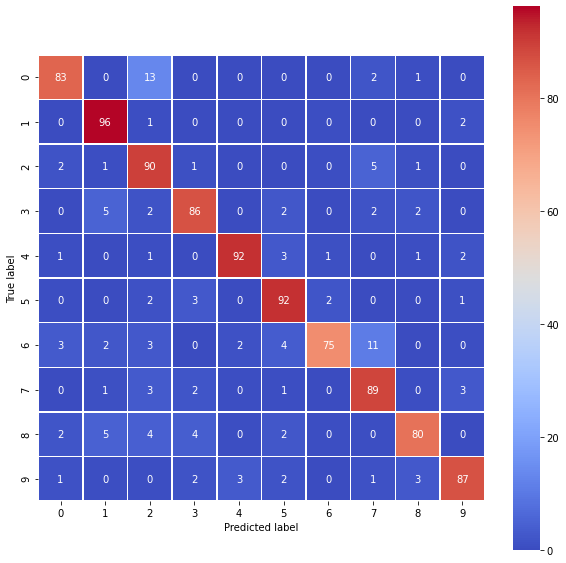

In [31]:
distribution_of_prediction_digits = pd.DataFrame(list(zip(np.arange(len(prediction_digits)), prediction_digits, target_digits)),
                                                               columns=['item', 'prediction', 'target'])   

distribution_of_prediction_digits_groups = distribution_of_prediction_digits.groupby('prediction').groups

target_list = distribution_of_prediction_digits['target'].to_list()
prediction_list = distribution_of_prediction_digits['prediction'].to_list()
for i in range(len(data_d)):
    target_list[i] = target_list[i].item()
    
precision = 0
for i in range(len(distribution_of_prediction_digits.index)):
    if distribution_of_prediction_digits['prediction'].iloc[i] == distribution_of_prediction_digits['target'].iloc[i]: 
        precision += 1

print(f'Precision of digits recognition = {precision/len(distribution_of_prediction_digits.index)*100 :.2f}%')

CM = confusion_matrix(target_list, prediction_list)

CM_normalized = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]*100
plt.subplots(figsize=(10, 10))
sn.heatmap(CM_normalized, annot=True, linewidths=.5, cmap='coolwarm', fmt='.0f', square=True);
plt.ylabel('True label');
plt.xlabel('Predicted label');

## Prediction of letters

In [32]:
for data_l, target_l in test_letter_loader:
    prediction_letters, target_letters = pred(mozafari, data_l.to("cuda"), target_l.to("cuda"))

Precision of letters recognition = 76.50%


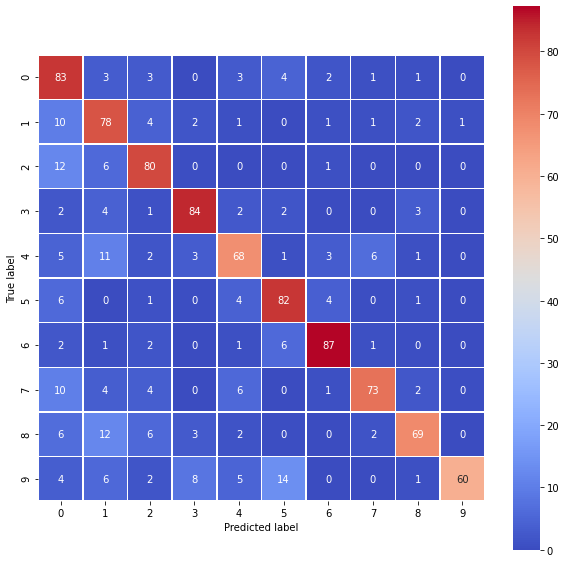

In [33]:
distribution_of_prediction_letters = pd.DataFrame(list(zip(np.arange(len(prediction_letters)), prediction_letters, target_letters)),
                                                               columns=['item', 'prediction', 'target'])   

distribution_of_prediction_letters_groups = distribution_of_prediction_letters.groupby('prediction').groups

target_list = distribution_of_prediction_letters['target'].to_list()
prediction_list = distribution_of_prediction_letters['prediction'].to_list()
for i in range(len(data_l)):
    target_list[i] = target_list[i].item()
    
precision = 0
for i in range(len(distribution_of_prediction_letters.index)):
    if distribution_of_prediction_letters['prediction'].iloc[i] == distribution_of_prediction_letters['target'].iloc[i]: 
        precision += 1

print(f'Precision of letters recognition = {precision/len(distribution_of_prediction_letters.index)*100 :.2f}%')

CM = confusion_matrix(target_list, prediction_list)

CM_normalized = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]*100
plt.subplots(figsize=(10, 10))
sn.heatmap(CM_normalized, annot=True, linewidths=.5, cmap='coolwarm', fmt='.0f', square=True);
plt.ylabel('True label');
plt.xlabel('Predicted label');